# Process Data

## Load Data

In [2]:
import pandas as pd

PATH = '../Twitter_Climate_Change_Dataset/twitter_sentiment_data.csv'
df = pd.read_csv(PATH)
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


Seperate Messages from the rest of the data, for NLP

In [18]:
sMessages = df['message']

## Plot Data

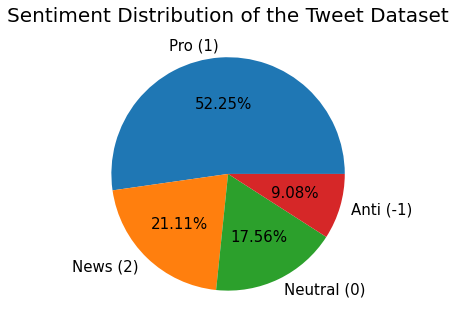

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize = (5, 5))
plt.pie(df.sentiment.value_counts().values, labels = ['Pro (1)', 'News (2)', 'Neutral (0)', 'Anti (-1)'], autopct = '%.2f%%', textprops={'fontsize': 15})
plt.title('Sentiment Distribution of the Tweet Dataset', fontsize=20)
plt.tight_layout()
plt.show()

# Pre-Processing

## Data Cleaning

Tweets often times have a lot of content that is not important for the meaning of the Tweet but rather for its operation within Twitter. Those can be things like the retweet-symbol ("RT") or the authors username. Those informations could be unimportant and there might want to be removed.
Things that will be removed by this function:
- Retweet-markers (The part of the tweet that looks like 'RT @Username: [...]')
- Twitter usernames (The part of the tweet that looks like '[...] @username [...]')

Hashtags will NOT be removed since they can hold important information about the content and sentiment of the tweet.

In [25]:
import re 

def removeTwitterContent(text):
    '''
    Clean the Text of ReTweet-symbols and usernames
    '''
    rt_removed_text = re.sub(r'RT @\w+: ', '', text)
    twitter_cleaned_text = re.sub(r'@\w+', '', rt_removed_text)
    return twitter_cleaned_text

sTwitter_cleansed = sMessages.apply(lambda x: removeTwitterContent(x))
print(sTwitter_cleansed.head())

0     climate change is an interesting hustle as it...
1    Watch #BeforeTheFlood right here, as  travels ...
2    Fabulous! Leonardo #DiCaprio's film on #climat...
3    Just watched this amazing documentary by leona...
4    Pranita Biswasi, a Lutheran from Odisha, gives...
Name: message, dtype: object


### Tokenization

Turn all tweets into tokens to handle them with more ease. A Token in this case is defined as a lower-cased word or a single punctuation.

In [30]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

def wordTokens (text):
    '''
    Create a list of lower-cased words and punctuations
    '''
    text = text.lower()
    tokenized_word = word_tokenize(text)
    return tokenized_word

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fkliemt\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [31]:
tokenized_messages = []
for message in sTwitter_cleansed:
    tokenized_message = wordTokens(message)
    tokenized_messages.append(tokenized_message)
print(tokenized_messages[4])

['pranita', 'biswasi', ',', 'a', 'lutheran', 'from', 'odisha', ',', 'gives', 'testimony', 'on', 'effects', 'of', 'climate', 'change', '&', 'amp', ';', 'natural', 'disasters', 'on', 'the', 'poã¢â‚¬â¦']


Remove Stopwords like "and", "the", "in" etc

In [61]:
from nltk.corpus import stopwords
import string
nltk.download('stopwords')

def removeStopwordsPunctuation(word_list):
    '''
    Clean the text of Stopwords and punctuation
    '''
    stopwordRemoved = [word for word in word_list if word not in stopwords.words('english')]
    stopAndPunctRemoved = [word for word in stopwordRemoved if word not in string.punctuation]
    
    return stopAndPunctRemoved


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fkliemt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
stopRemoved_tokens = [removeStopwordsPunctuation(message) for message in tokenized_messages]
# stopRemoved_tokens = removeStopwordsPunctuation(["hello", "the", ","])
print(stopRemoved_tokens)

In [ ]:
def lemmatizeWords(text):
    '''
    Lemmatize the text that is put in
    '''

In [2]:
import nltk
from nltk.corpus import wordnet

def negations (sentence):
    '''
    Turn negated words into cognitive synonyms. (Source: https://gist.github.com/UtkarshRedd/3fbfd354ea7a6f83bd8f9419a27b0543#file-negation_handler-py)
    '''
    temp = int(0)
    for i in range(len(sentence)):
        if sentence[i-1] in ['not',"n't"]:
            antonyms = []
            for syn in wordnet.synsets(sentence[i]):
                syns = wordnet.synsets(sentence[i])
                w1 = syns[0].name()
                temp = 0
                for l in syn.lemmas():
                    if l.antonyms():
                        antonyms.append(l.antonyms()[0].name())
                max_dissimilarity = 0
                for ant in antonyms:
                    syns = wordnet.synsets(ant)
                    w2 = syns[0].name()
                    syns = wordnet.synsets(sentence[i])
                    w1 = syns[0].name()
                    word1 = wordnet.synset(w1)
                    word2 = wordnet.synset(w2)
                    if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
                        temp = 1 - word1.wup_similarity(word2)
                    if temp>max_dissimilarity:
                        max_dissimilarity = temp
                        antonym_max = ant
                        sentence[i] = antonym_max
                        sentence[i-1] = ''
    while '' in sentence:
        sentence.remove('')
    return sentence

In [ ]:
def bigrams (text):
    '''
    Tokenize texts as bigrams. Not Higher because it causes very
    sparse feature vectors.
    '''

### Data Plots

First we flatten the nested lists into a list that contains all the single tokens of all messages. This makes it possible to count how many times a token occures across all the messages.

In [10]:
import itertools

joined_tokens = list(itertools.chain.from_iterable(tokenized_messages))

was


To gain a overview on how our data looks like, we'll proceed to plot some of the data.

In [23]:
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plotOccurences(token_list):
    fdist = FreqDist(token_list)
    df_fdist = pd.DataFrame(fdist.items(), columns=['Token', 'Occurences'])
    # fdist.plot(30,cumulative=False)
    # plt.show()
    df_fdist.head()
    sns.set(font_scale = 1.3)
    plt.figure(figsize=(5, 5))
    plt.title("Top 20 Occurrences of Tokens in all messages")
    sns.set_style('darkgrid')
    sns.barplot(x="Occurences", y="Token", data=df_fdist.sort_values('Occurences', ascending=False).head(20), palette="flare")

#### Plot Raw Data

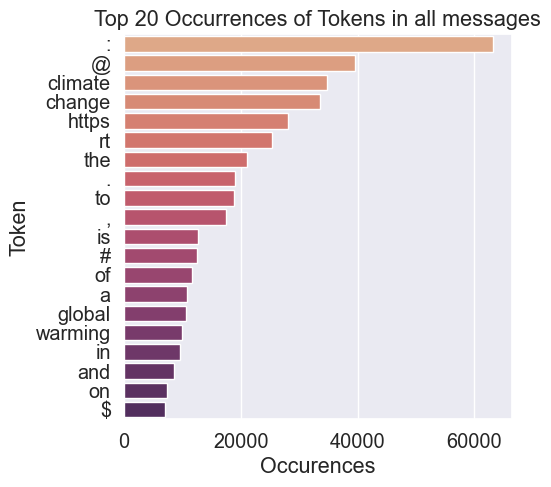

In [24]:
plotOccurences(joined_tokens)

# Feature Engineering

## Bag of Words

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
sentences = []
for tweet in tokenized_messages:

    sentence  = ' '.join(tweet)
    sentences.append(sentence)
cv = CountVectorizer(binary=True)
print(sentences[9])
cv.fit(sentences)
vectorizedMessages = cv.transform(sentences)

# beforetheflood watch # beforetheflood right here , as @ leodicaprio travels the world to tackle climate change ... https : //t.co/hcizrpuhlf


## Tf-Idf

# Model Development

In [9]:
from sklearn import metrics

def evaluateModel(model, X_test, y_test, title):
    '''
    print out classification scores
    :param model: used model
    :param X_test:
    :param y_test:
    :param title: title of the model
    '''
    print("\n*** " + title + " ***")
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions, average='weighted')
    precision = metrics.precision_score(y_test, predictions, average='weighted')
    f1 = metrics.f1_score(y_test, predictions, average='weighted')

    clsScoreDict = {
        "accuracy": accuracy
        , "recall": recall
        , "precision": precision
        , "f1": f1
    }

    print("Accuracy:  " + str(accuracy))
    print("Precision: " + str(precision))
    print("Recall:    " + str(recall))
    print("F1:        " + str(f1))
    print("\n\n")

    return clsScoreDict

### Split Dataset

In [10]:
from sklearn.model_selection import train_test_split

target = df['sentiment']
X = vectorizedMessages

X_train, X_test, y_train, y_test = train_test_split(
        X, target, train_size=0.75
    )

## Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
clfModel = model.fit(X_train, y_train)
clsScoreDict = evaluateModel(clfModel, X_test, y_test, 'LogisticRegression')


*** LogisticRegression ***
Accuracy:  0.740123793919534
Precision: 0.7362025847429119
Recall:    0.740123793919534
F1:        0.7353891870356344





/home/freddy/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Naive Bayes Classifier

In [11]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
nbModel = gnb.fit(X_train.toarray(), y_train)
nbScores = evaluateModel(nbModel, X_test.toarray(), y_test, 'LogisticRegression')


*** LogisticRegression ***
Accuracy:  0.4832514108865829
Precision: 0.5732034499640579
Recall:    0.4832514108865829
F1:        0.5010217819991687





# Model Evaluation